# Trading With the Market: Turning Regimes Into Risk Control

### Motivation

During my experience as a trader, I realized that most strategies I used worked beautifully in trending markets, but failed during bear phases, sideways corrections, or volatility spikes. Profits built over weeks often got erased in just a few bad phases.

That’s when I realized:

> **Trading strategies don’t fail because the logic is wrong. They fail because they are used in the wrong market environment.**

This project is an attempt to translate that qualitative understanding into a quantitative framework.

---

## Project Overview

In this notebook, we build a complete regime-based trading framework to:

- Understand market behavior using price and breadth data  
- Classify markets into bull, bear, high-volatility, and low-volatility regimes using Random Forest Model
- Stabilize noisy signals using persistence filters  
- Construct a four-regime adaptive exposure strategy and a Crash Hedge Strategy
- Add realistic execution logic  
- Backtest and evaluate performance against Buy & Hold  

The focus is not on predicting prices, but on:

> **Adapting risk and position sizing to changing market regimes.**


## Steps to Perform in This Project

1. Import libraries and load market data  
2. Build index-level and market breadth inputs
5. Define raw market regimes using rolling statistics  
3. Engineer trend, volatility, and breadth-based features  
4. Perform quality checks on features  
7. Train ML Models for Regime Classification
8. Classification Metrics for Each Regime  
9. Understand Feature Importance
10. Backtest the strategy   

Let’s begin!


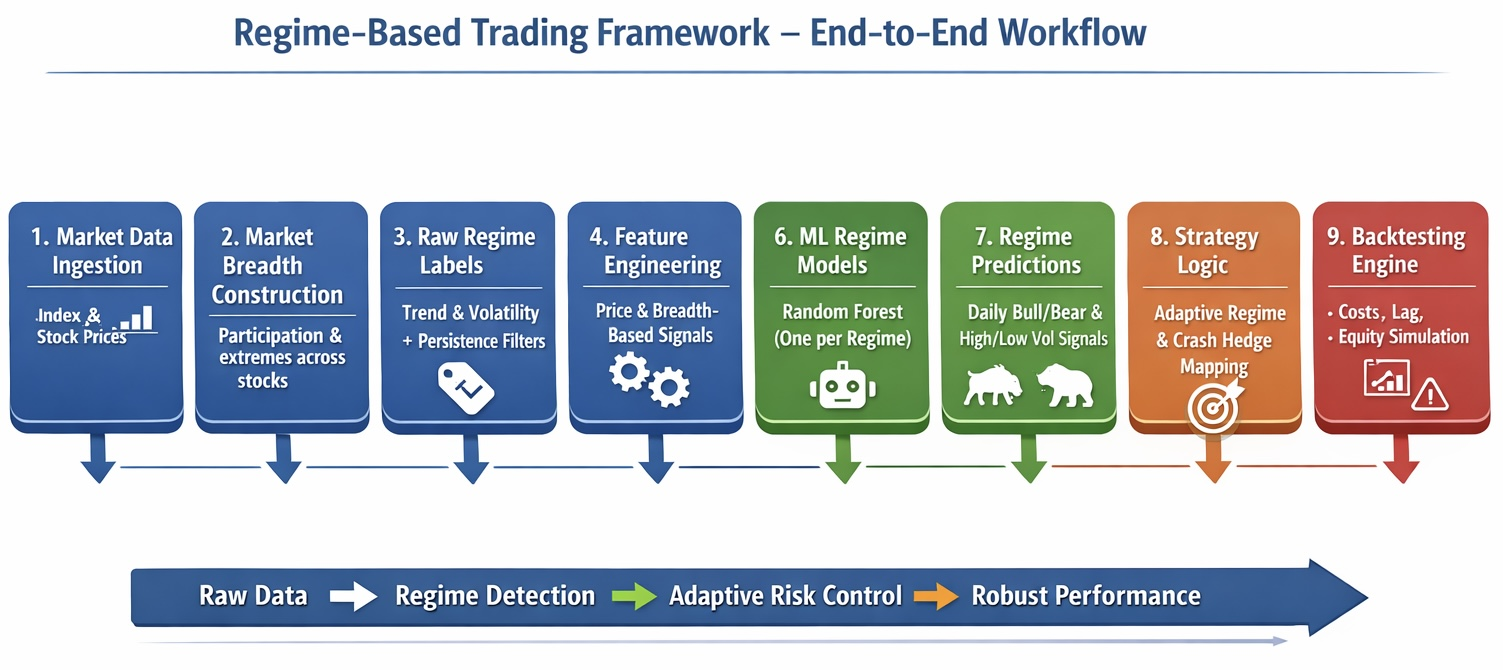

In [ ]:
# importing necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Index Data and Market Breadth Inputs

We start by building the primary data sources for the project.

- First, we download daily OHLCV data for a broad market index.
- Second, using all individual stocks within the index universe, we compute **market breadth metrics** that describe what’s happening beneath the surface.

Market breadth captures:
- Number of stocks above/below key moving averages  
- Number of stocks with large daily moves  
- Participation across the universe  

This helps us avoid relying only on index prices, which can often be dominated by a few large-cap stocks.


In [ ]:
def fetch_historical_data(symbol, start_date, end_date):
    # Download historical data
    # threads=True speeds up download when fetching multiple symbols
    # group_by="symbol" ensures consistent structure across assets

  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")

    # yfinance returns MultiIndex columns when group_by="symbol" is used
    # For single-symbol downloads, flatten columns to standard OHLCV format

  if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(1)
  return data

In [ ]:
def calculate_daily_indicators(data):
  #Computing basic daily indicators used for calculating Market Breadth
    data['MA20'] = data['Close'].rolling(window=20, min_periods=1).mean()     #calculating MA20
    data['MA50'] = data['Close'].rolling(window=50, min_periods=1).mean()     #calculating MA50
    data['Daily_Return'] = data['Close'].pct_change() * 100                   #percentage change in a day
    data['5Day_Return'] = (data['Close'] / data['Close'].shift(5) - 1) * 100  #percentage change in 5 days
    return data

In [ ]:
def scan_single_stock_historical(symbol, start_date, end_date):
    """
    Scans historical price data for a single stock and generates
    daily technical condition flags.Then it returns a list of daily signal dictionaries
    """
    data = fetch_historical_data(symbol, start_date, end_date)

    data = calculate_daily_indicators(data)
    results = []

    # Start from index 50 to ensure MA50 is fully formed
    for i in range(50, len(data)):
        day = data.iloc[i]

    # Build a daily signal snapshot
        results.append({
            'Symbol': symbol,
            'Date': day.name.strftime('%Y-%m-%d'),

            # Price & volume
            'Close': day['Close'],
            'Volume': day['Volume'],

            # Moving averages
            'MA20': day['MA20'],
            'MA50': day['MA50'],

            # Returns
            'Daily_Return': day['Daily_Return'],
            '5Day_Return': day['5Day_Return'],

            # Trend conditions
            'Above_MA20': day['Close'] > day['MA20'],
            'Below_MA20': day['Close'] < day['MA20'],
            'Above_MA50': day['Close'] > day['MA50'],
            'Below_MA50': day['Close'] < day['MA50'],

            # Large daily move flags (momentum / shock detection)
            'Up_4.5pct_Today': day['Daily_Return'] >= 4.5,
            'Down_4.5pct_Today': day['Daily_Return'] <= -4.5,

            # Large multi-day move flags (short-term momentum)
            'Up_20pct_5Days': day['5Day_Return'] >= 20,
            'Down_20pct_5Days': day['5Day_Return'] <= -20
        })
    return results

In [ ]:
def scan_all_stocks(symbols, start_date, end_date):
#Runs the historical scanner across a list of symbols and aggregates results.
  all_results = []
  for symbol in symbols:
    res = scan_single_stock_historical(symbol, start_date, end_date)
    all_results.extend(res)
    print(f"{symbol}: {len(res)} days processed")
  return pd.DataFrame(all_results)

In [ ]:
def generate_daily_summary(df):
   """
    Generates a daily market breadth summary from stock-level scan results.

    For each trading day, this function aggregates:
    - Total number of stocks scanned
    - Trend participation (Stocks above and below MA20 & MA50)
    - Momentum extremes (Price moved 5% in a day,Price moved 20% in past 5 days)

    """
   daily_summary = df.groupby('Date').agg({
        'Symbol': 'count',
        'Above_MA20': 'sum',
        'Below_MA20': 'sum',
        'Above_MA50': 'sum',
        'Below_MA50': 'sum',
        'Up_4.5pct_Today': 'sum',
        'Down_4.5pct_Today': 'sum',
        'Up_20pct_5Days': 'sum',
        'Down_20pct_5Days': 'sum'
    }).reset_index()

   daily_summary.columns = [
        'Date', 'Total_Stocks_Scanned',
        'Stocks_Above_MA20', 'Stocks_Below_MA20',
        'Stocks_Above_MA50', 'Stocks_Below_MA50',
        'Stocks_Up_4.5pct_Today', 'Stocks_Down_4.5pct_Today',
        'Stocks_Up_20pct_5Days', 'Stocks_Down_20pct_5Days'
    ]
   return daily_summary.sort_values('Date')

In [ ]:
def save_detailed_results(df, filename="data.csv"):
  #saves as a csv file
    df.to_csv(filename, index=False)
    print(f"✅ Saved: {filename}")

In [ ]:
if __name__ == "__main__":
    # Load symbols from file that containes names of stocks in NIFTY500 (downloaded from NSE website)
    df_symbols = pd.read_csv("ind_nifty500list.csv")[['Symbol']].copy()
    df_symbols['Yahoo_Symbol'] = df_symbols['Symbol'] + '.NS'
    symbols = df_symbols['Yahoo_Symbol'].tolist()

    #defines historical scan window
    start_date = "2015-01-01"
    end_date = "2025-11-30"

    # Scans across all stocks
    all_results_df = scan_all_stocks(symbols, start_date, end_date)
    save_detailed_results(all_results_df, "all_stock_data.csv")

    # Generate and save market breadth summary
    daily_summary_df = generate_daily_summary(all_results_df)
    save_detailed_results(daily_summary_df, "daily_summary.csv")

/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


360ONE.NS: 1484 days processed


[*********************100%***********************]  1 of 1 completed


3MINDIA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ABB.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ACC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


ACMESOLAR.NS: 210 days processed


[*********************100%***********************]  1 of 1 completed


AIAENG.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


APLAPOLLO.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


AUBANK.NS: 2024 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


AWL.NS: 892 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


AADHARHFC.NS: 335 days processed


[*********************100%***********************]  1 of 1 completed


AARTIIND.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


AAVAS.NS: 1715 days processed


[*********************100%***********************]  1 of 1 completed


ABBOTINDIA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ACE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


ADANIENSOL.NS: 511 days processed


[*********************100%***********************]  1 of 1 completed


ADANIENT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ADANIGREEN.NS: 1791 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ADANIPORTS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ADANIPOWER.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ATGL.NS: 1697 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ABCAPITAL.NS: 1988 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ABFRL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


ABLBL.NS: 59 days processed


[*********************100%***********************]  1 of 1 completed


ABREL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


ABSLAMC.NS: 974 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


AEGISLOG.NS: 321 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


AEGISVOPAK.NS: 76 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


AFCONS.NS: 217 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


AFFLE.NS: 1511 days processed


[*********************100%***********************]  1 of 1 completed


AJANTPHARM.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


AKUMS.NS: 274 days processed


[*********************100%***********************]  1 of 1 completed


AKZOINDIA.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


APLLTD.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ALKEM.NS: 2405 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ALKYLAMINE.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ALOKINDS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


ARE&M.NS: 468 days processed


[*********************100%***********************]  1 of 1 completed


AMBER.NS: 1885 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


AMBUJACEM.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


ANANDRATHI.NS: 931 days processed


[*********************100%***********************]  1 of 1 completed


ANANTRAJ.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


ANGELONE.NS: 1227 days processed


[*********************100%***********************]  1 of 1 completed


APARINDS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


APOLLOHOSP.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


APOLLOTYRE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


APTUS.NS: 1007 days processed


[*********************100%***********************]  1 of 1 completed


ASAHIINDIA.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ASHOKLEY.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ASIANPAINT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


ASTERDM.NS: 1867 days processed


[*********************100%***********************]  1 of 1 completed


ASTRAZEN.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ASTRAL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


ATHERENERG.NS: 95 days processed


[*********************100%***********************]  1 of 1 completed


ATUL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


AUROPHARMA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


AIIL.NS: 346 days processed


[*********************100%***********************]  1 of 1 completed


DMART.NS: 2100 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


AXISBANK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BASF.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BEML.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BLS.NS: 2288 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


BSE.NS: 2130 days processed


[*********************100%***********************]  1 of 1 completed


BAJAJ-AUTO.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BAJFINANCE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BAJAJFINSV.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BAJAJHLDNG.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


BAJAJHFL.NS: 251 days processed


[*********************100%***********************]  1 of 1 completed


BALKRISIND.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BALRAMCHIN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


BANDHANBNK.NS: 1847 days processed


[*********************100%***********************]  1 of 1 completed


BANKBARODA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BANKINDIA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MAHABANK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BATAINDIA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BAYERCROP.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BERGEPAINT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BDL.NS: 1849 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BEL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BHARATFORG.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BHEL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BPCL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BHARTIARTL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


BHARTIHEXA.NS: 355 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


BIKAJI.NS: 702 days processed


[*********************100%***********************]  1 of 1 completed


BIOCON.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BSOFT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BLUEDART.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


BLUEJET.NS: 464 days processed


[*********************100%***********************]  1 of 1 completed


BLUESTARCO.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BBTC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BOSCHLTD.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


FIRSTCRY.NS: 273 days processed


[*********************100%***********************]  1 of 1 completed


BRIGADE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


BRITANNIA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


MAPMYINDIA.NS: 926 days processed


[*********************100%***********************]  1 of 1 completed


CCL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CESC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CGPOWER.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CRISIL.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CAMPUS.NS: 833 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CANFINHOME.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CANBK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CAPLIPOINT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CGCL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CARBORUNIV.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CASTROLIND.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CEATLTD.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CENTRALBK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CDSL.NS: 2031 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CENTURYPLY.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CERA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


CHALET.NS: 1632 days processed


[*********************100%***********************]  1 of 1 completed


CHAMBLFERT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CHENNPETRO.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


CHOICEIN.NS: 851 days processed


[*********************100%***********************]  1 of 1 completed


CHOLAHLDNG.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CHOLAFIN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CIPLA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CUB.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


CLEAN.NS: 1031 days processed


[*********************100%***********************]  1 of 1 completed


COALINDIA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


COCHINSHIP.NS: 2001 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


COFORGE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


COHANCE.NS: 92 days processed


[*********************100%***********************]  1 of 1 completed


COLPAL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


CAMS.NS: 1227 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


CONCORDBIO.NS: 514 days processed


[*********************100%***********************]  1 of 1 completed


CONCOR.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


COROMANDEL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


CRAFTSMAN.NS: 1108 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


CREDITACC.NS: 1745 days processed


[*********************100%***********************]  1 of 1 completed


CROMPTON.NS: 2311 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CUMMINSIND.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


CYIENT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


DCMSHRIRAM.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


DLF.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


DOMS.NS: 431 days processed


[*********************100%***********************]  1 of 1 completed


DABUR.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


DALBHARAT.NS: 1664 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


DATAPATTNS.NS: 923 days processed


[*********************100%***********************]  1 of 1 completed


DEEPAKFERT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


DEEPAKNTR.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


DELHIVERY.NS: 822 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


DEVYANI.NS: 1012 days processed


[*********************100%***********************]  1 of 1 completed


DIVISLAB.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


DIXON.NS: 1977 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


AGARWALEYE.NS: 153 days processed


[*********************100%***********************]  1 of 1 completed


LALPATHLAB.NS: 2405 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


DRREDDY.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: DUMMYTATAM.NS"}}}
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DUMMYTATAM.NS']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


DUMMYTATAM.NS: 0 days processed


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: DUMMYDBRLT.NS"}}}
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DUMMYDBRLT.NS']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


DUMMYDBRLT.NS: 0 days processed


[*********************100%***********************]  1 of 1 completed


EIDPARRY.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


EIHOTEL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


EICHERMOT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ELECON.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ELGIEQUIP.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


EMAMILTD.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


EMCURE.NS: 292 days processed


[*********************100%***********************]  1 of 1 completed


ENDURANCE.NS: 2204 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ENGINERSIN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ERIS.NS: 2031 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ESCORTS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


ETERNAL.NS: 1006 days processed


[*********************100%***********************]  1 of 1 completed


EXIDEIND.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


NYKAA.NS: 954 days processed


[*********************100%***********************]  1 of 1 completed


FEDERALBNK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


FACT.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


FINCABLES.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


FINPIPE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


FSL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


FIVESTAR.NS: 699 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


FORCEMOT.NS: 1465 days processed


[*********************100%***********************]  1 of 1 completed


FORTIS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GAIL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GVT&D.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GMRAIRPORT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GRSE.NS: 1705 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GICRE.NS: 1952 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GILLETTE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


GLAND.NS: 1193 days processed


[*********************100%***********************]  1 of 1 completed


GLAXO.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GLENMARK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


MEDANTA.NS: 699 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


GODIGIT.NS: 329 days processed


[*********************100%***********************]  1 of 1 completed


GPIL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GODFRYPHLP.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GODREJAGRO.NS: 1958 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GODREJCP.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GODREJIND.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GODREJPROP.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GRANULES.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GRAPHITE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GRASIM.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GRAVITA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GESHIP.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


FLUOROCHEM.NS: 1468 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GUJGASLTD.NS: 2468 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GMDCLTD.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


GSPL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


HEG.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


HBLENGINE.NS: 190 days processed


[*********************100%***********************]  1 of 1 completed


HCLTECH.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


HDFCAMC.NS: 1756 days processed


[*********************100%***********************]  1 of 1 completed


HDFCBANK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


HDFCLIFE.NS: 1935 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


HFCL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


HAPPSTMNDS.NS: 1238 days processed


[*********************100%***********************]  1 of 1 completed


HAVELLS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


HEROMOTOCO.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


HEXT.NS: 140 days processed


[*********************100%***********************]  1 of 1 completed


HSCL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


HINDALCO.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


HAL.NS: 1845 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


HINDCOPPER.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


HINDPETRO.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


HINDUNILVR.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


HINDZINC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


POWERINDIA.NS: 1355 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


HOMEFIRST.NS: 1143 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


HONASA.NS: 459 days processed


[*********************100%***********************]  1 of 1 completed


HONAUT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


HUDCO.NS: 2060 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


HYUNDAI.NS: 226 days processed


[*********************100%***********************]  1 of 1 completed


ICICIBANK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ICICIGI.NS: 1970 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ICICIPRULI.NS: 2216 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


IDBI.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


IDFCFIRSTB.NS: 2435 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


IFCI.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


IIFL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


INOXINDIA.NS: 430 days processed


[*********************100%***********************]  1 of 1 completed


IRB.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


IRCON.NS: 1721 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


ITCHOTELS.NS: 156 days processed


[*********************100%***********************]  1 of 1 completed


ITC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ITI.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


INDGN.NS: 337 days processed


[*********************100%***********************]  1 of 1 completed


INDIACEM.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


INDIAMART.NS: 1536 days processed


[*********************100%***********************]  1 of 1 completed


INDIANB.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


IEX.NS: 1954 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


INDHOTEL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


IOC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


IOB.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


IRCTC.NS: 1470 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


IRFC.NS: 1146 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


IREDA.NS: 446 days processed


[*********************100%***********************]  1 of 1 completed


IGL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


INDUSTOWER.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


INDUSINDBK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NAUKRI.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


INFY.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


INOXWIND.NS: 2580 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


INTELLECT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


INDIGO.NS: 2433 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


IGIL.NS: 183 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


IKS.NS: 185 days processed


[*********************100%***********************]  1 of 1 completed


IPCALAB.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


JBCHEPHARM.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


JKCEMENT.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


JBMA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


JKTYRE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


JMFINANCIL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


JSWENERGY.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


JSWINFRA.NS: 479 days processed


[*********************100%***********************]  1 of 1 completed


JSWSTEEL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


JPPOWER.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


J&KBANK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


JINDALSAW.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


JSL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


JINDALSTEL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


JIOFIN.NS: 508 days processed


[*********************100%***********************]  1 of 1 completed


JUBLFOOD.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


JUBLINGREA.NS: 1112 days processed


[*********************100%***********************]  1 of 1 completed


JUBLPHARMA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


JWL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


JYOTHYLAB.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


JYOTICNC.NS: 413 days processed


[*********************100%***********************]  1 of 1 completed


KPRMILL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


KEI.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


KPITTECH.NS: 1586 days processed


[*********************100%***********************]  1 of 1 completed


KSB.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


KAJARIACER.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


KPIL.NS: 552 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


KALYANKJIL.NS: 1107 days processed


[*********************100%***********************]  1 of 1 completed


KARURVYSYA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


KAYNES.NS: 698 days processed


[*********************100%***********************]  1 of 1 completed


KEC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


KFINTECH.NS: 671 days processed


[*********************100%***********************]  1 of 1 completed


KIRLOSBROS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


KIRLOSENG.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


KOTAKBANK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


KIMS.NS: 1045 days processed


[*********************100%***********************]  1 of 1 completed


LTF.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


LTTS.NS: 2220 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


LICHSGFIN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


LTFOODS.NS: 461 days processed


[*********************100%***********************]  1 of 1 completed


LTIM.NS: 2263 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


LT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


LATENTVIEW.NS: 946 days processed


[*********************100%***********************]  1 of 1 completed


LAURUSLABS.NS: 2163 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


THELEELA.NS: 74 days processed


[*********************100%***********************]  1 of 1 completed


LEMONTREE.NS: 1840 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


LICI.NS: 827 days processed


[*********************100%***********************]  1 of 1 completed


LINDEINDIA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


LLOYDSME.NS: 537 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


LODHA.NS: 1094 days processed


[*********************100%***********************]  1 of 1 completed


LUPIN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MMTC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MRF.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MGL.NS: 2276 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MAHSCOOTER.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MAHSEAMLES.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


M&MFIN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


M&M.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MANAPPURAM.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MRPL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


MANKIND.NS: 585 days processed


[*********************100%***********************]  1 of 1 completed


MARICO.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MARUTI.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MFSL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


MAXHEALTH.NS: 1257 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


MAZDOCK.NS: 1222 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


METROPOLIS.NS: 1588 days processed


[*********************100%***********************]  1 of 1 completed


MINDACORP.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


MSUMI.NS: 860 days processed


[*********************100%***********************]  1 of 1 completed


MOTILALOFS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MPHASIS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MCX.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MUTHOOTFIN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NATCOPHARM.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NBCC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NCC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NHPC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NLCINDIA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NMDC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


NSLNISP.NS: 635 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


NTPCGREEN.NS: 202 days processed


[*********************100%***********************]  1 of 1 completed


NTPC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NH.NS: 2396 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NATIONALUM.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NAVA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NAVINFLUOR.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NESTLEIND.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


NETWEB.NS: 529 days processed


[*********************100%***********************]  1 of 1 completed


NEULANDLAB.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NEWGEN.NS: 1886 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NAM-INDIA.NS: 1944 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


NIVABUPA.NS: 209 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


NUVAMA.NS: 487 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


NUVOCO.NS: 1007 days processed


[*********************100%***********************]  1 of 1 completed


OBEROIRLTY.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ONGC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


OIL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


OLAELEC.NS: 276 days processed


[*********************100%***********************]  1 of 1 completed


OLECTRA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


PAYTM.NS: 948 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


ONESOURCE.NS: 161 days processed


[*********************100%***********************]  1 of 1 completed


OFSS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


POLICYBZR.NS: 951 days processed


[*********************100%***********************]  1 of 1 completed


PCBL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


PGEL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


PIIND.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


PNBHOUSING.NS: 2192 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


PTCIL.NS: 562 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


PVRINOX.NS: 686 days processed


[*********************100%***********************]  1 of 1 completed


PAGEIND.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


PATANJALI.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


PERSISTENT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


PETRONET.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


PFIZER.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


PHOENIXLTD.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


PIDILITIND.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


PPLPHARMA.NS: 720 days processed


[*********************100%***********************]  1 of 1 completed


POLYMED.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


POLYCAB.NS: 1588 days processed


[*********************100%***********************]  1 of 1 completed


POONAWALLA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


PFC.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


POWERGRID.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


PRAJIND.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


PREMIERENE.NS: 260 days processed


[*********************100%***********************]  1 of 1 completed


PRESTIGE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


PGHH.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


PNB.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


RRKABEL.NS: 488 days processed


[*********************100%***********************]  1 of 1 completed


RBLBANK.NS: 2235 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


RECLTD.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


RHIM.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


RITES.NS: 1780 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


RADICO.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


RVNL.NS: 1591 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


RAILTEL.NS: 1126 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


RAINBOW.NS: 831 days processed


[*********************100%***********************]  1 of 1 completed


RKFORGE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


RCF.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


REDINGTON.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


RELIANCE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


RELINFRA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


RPOWER.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


SBFC.NS: 511 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


SBICARD.NS: 1365 days processed


[*********************100%***********************]  1 of 1 completed


SBILIFE.NS: 1967 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SJVN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SKFINDIA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SRF.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


SAGILITY.NS: 211 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


SAILIFE.NS: 187 days processed


[*********************100%***********************]  1 of 1 completed


SAMMAANCAP.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


MOTHERSON.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


SAPPHIRE.NS: 947 days processed


[*********************100%***********************]  1 of 1 completed


SARDAEN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SAREGAMA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SCHAEFFLER.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SCHNEIDER.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SCI.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SHREECEM.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SHRIRAMFIN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


SHYAMMETL.NS: 1047 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


ENRIN.NS: 61 days processed


[*********************100%***********************]  1 of 1 completed


SIEMENS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


SIGNATURE.NS: 486 days processed


[*********************100%***********************]  1 of 1 completed


SOBHA.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SOLARINDS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


SONACOMS.NS: 1048 days processed


[*********************100%***********************]  1 of 1 completed


SONATSOFTW.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


STARHEALTH.NS: 932 days processed


[*********************100%***********************]  1 of 1 completed


SBIN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SAIL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


SUMICHEM.NS: 1398 days processed


[*********************100%***********************]  1 of 1 completed


SUNPHARMA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SUNTV.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SUNDARMFIN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SUNDRMFAST.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SUPREMEIND.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SUZLON.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


SWANCORP.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


SWIGGY.NS: 210 days processed


[*********************100%***********************]  1 of 1 completed


SYNGENE.NS: 2494 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


SYRMA.NS: 756 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


TBOTEK.NS: 334 days processed


[*********************100%***********************]  1 of 1 completed


TVSMOTOR.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TATACHEM.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TATACOMM.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TCS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TATACONSUM.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TATAELXSI.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TATAINVEST.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TATAMOTORS.NS']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


TATAMOTORS.NS: 0 days processed


[*********************100%***********************]  1 of 1 completed


TATAPOWER.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TATASTEEL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


TATATECH.NS: 440 days processed


[*********************100%***********************]  1 of 1 completed


TTML.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TECHM.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TECHNOE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TEJASNET.NS: 2034 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


NIACL.NS: 1939 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


RAMCOCEM.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


THERMAX.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TIMKEN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TITAGARH.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TITAN.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TORNTPHARM.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TORNTPOWER.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TARIL.NS: 2644 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TRENT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TRIDENT.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TRIVENI.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TRITURBINE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


TIINDIA.NS: 1946 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


UCOBANK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


UNOMINDA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


UPL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


UTIAMC.NS: 1221 days processed


[*********************100%***********************]  1 of 1 completed


ULTRACEMCO.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


UNIONBANK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


UBL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


UNITDSPR.NS: 321 days processed


[*********************100%***********************]  1 of 1 completed


USHAMART.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


VGUARD.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


DBREALTY.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


VTL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


VBL.NS: 2191 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


MANYAVAR.NS: 886 days processed


[*********************100%***********************]  1 of 1 completed


VEDL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


VENTIVE.NS: 179 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


VIJAYA.NS: 993 days processed


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


VMM.NS: 187 days processed


[*********************100%***********************]  1 of 1 completed


IDEA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


VOLTAS.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")


WAAREEENER.NS: 222 days processed


[*********************100%***********************]  1 of 1 completed


WELCORP.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


WELSPUNLIV.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


WHIRLPOOL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


WIPRO.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


WOCKPHARMA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


YESBANK.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ZFCVINDIA.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ZEEL.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ZENTEC.NS: 2586 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ZENSARTECH.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ZYDUSLIFE.NS: 2645 days processed


/tmp/ipython-input-3365963335.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol,start=start_date,end=end_date,threads=True,group_by="symbol")
[*********************100%***********************]  1 of 1 completed


ECLERX.NS: 2645 days processed
✅ Saved: all_stock_data.csv
✅ Saved: daily_summary.csv


In [ ]:
#loads the csv file created as data
data = pd.read_csv("daily_summary.csv",index_col=0,parse_dates=True)
data

Total_Stocks_Scanned  Stocks_Above_MA20  Stocks_Below_MA20  \
Date                                                                     
2015-03-17                   320                133                185   
2015-03-18                   320                139                179   
2015-03-19                   320                122                196   
2015-03-20                   320                 89                229   
2015-03-23                   320                 76                242   
...                          ...                ...                ...   
2025-11-24                   499                139                360   
2025-11-25                   499                141                358   
2025-11-26                   499                198                301   
2025-11-27                   499                193                306   
2025-11-28                   499                183                316   

            Stocks_Above_MA50  Stocks_Below_MA50  Stocks_Up_4.5pct_Today  \
Date                                                                       
2015-03-17                169                150                      12   
2015-03-18                168                150                      10   
2015-03-19                160                158                       4   
2015-03-20                137                181                       4   
2015-03-23                128                190                       5   
...                       ...                ...                     ...   
2025-11-24                178                321                       8   
2025-11-25                175                324                       3   
2025-11-26                210                289                      11   
2025-11-27                211                288                       5   
2025-11-28                204                295                       1   

            Stocks_Down_4.5pct_Today  Stocks_Up_20pct_5Days  \
Date                                                          
2015-03-17                         2                      2   
2015-03-18                         4                      2   
2015-03-19                         9                      0   
2015-03-20                        28                      0   
2015-03-23                        19                      0   
...                              ...                    ...   
2025-11-24                         7                      0   
2025-11-25                         0                      0   
2025-11-26                         1                      0   
2025-11-27                         2                      0   
2025-11-28                         0                      0   

            Stocks_Down_20pct_5Days  
Date                                 
2015-03-17                        0  
2015-03-18                        0  
2015-03-19                        1  
2015-03-20                        1  
2015-03-23                        1  
...                             ...  
2025-11-24                        0  
2025-11-25                        0  
2025-11-26                        0  
2025-11-27                        0  
2025-11-28                        0  

[2645 rows x 9 columns]

In [ ]:
#downloads the file in an excel format
data.to_excel("daily_stock_summary.xlsx", index=False)

In [ ]:
#downloads OHLCV data of NIFTY500 for the desired period
nifty500_data = yf.download("^CRSLDX", start="2015-01-01", end="2025-12-30")
if isinstance(nifty500_data.columns, pd.MultiIndex):
    nifty500_data.columns = nifty500_data.columns.get_level_values(0)

/tmp/ipython-input-1159372417.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty500_data = yf.download("^CRSLDX", start="2015-01-01", end="2025-12-30")
[*********************100%***********************]  1 of 1 completed


In [ ]:
nifty500_data

Price              Close          High           Low          Open    Volume
Date                                                                        
2015-01-01   6786.091309   6794.241200   6754.991251   6767.591333   4409100
2015-01-02   6866.441406   6883.040994   6792.391208   6792.391208   6177400
2015-01-05   6857.441406   6913.241139   6848.241223   6877.341283   6143300
2015-01-06   6656.791016   6817.640901   6646.391127   6817.640901   7169100
2015-01-07   6644.941406   6680.491164   6605.391166   6653.641102   7233000
...                  ...           ...           ...           ...       ...
2025-12-22  23867.650391  23878.650391  23743.250000  23760.949219  25155300
2025-12-23  23895.150391  23929.250000  23825.150391  23906.099609  26039700
2025-12-24  23850.250000  23956.800781  23836.550781  23903.099609  19661100
2025-12-26  23780.250000  23885.349609  23752.550781  23841.949219  22264400
2025-12-29  23670.650391  23826.750000  23668.500000  23804.400391         0

[2706 rows x 5 columns]

In [ ]:
print(data.shape)
print(data.columns)
print(data.info())

(2645, 9)
Index(['Total_Stocks_Scanned', 'Stocks_Above_MA20', 'Stocks_Below_MA20',
       'Stocks_Above_MA50', 'Stocks_Below_MA50', 'Stocks_Up_4.5pct_Today',
       'Stocks_Down_4.5pct_Today', 'Stocks_Up_20pct_5Days',
       'Stocks_Down_20pct_5Days'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2645 entries, 2015-03-17 to 2025-11-28
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Total_Stocks_Scanned      2645 non-null   int64
 1   Stocks_Above_MA20         2645 non-null   int64
 2   Stocks_Below_MA20         2645 non-null   int64
 3   Stocks_Above_MA50         2645 non-null   int64
 4   Stocks_Below_MA50         2645 non-null   int64
 5   Stocks_Up_4.5pct_Today    2645 non-null   int64
 6   Stocks_Down_4.5pct_Today  2645 non-null   int64
 7   Stocks_Up_20pct_5Days     2645 non-null   int64
 8   Stocks_Down_20pct_5Days   2645 non-null   int64
dtypes: int64(9)
m

In [ ]:
print(nifty500_data.shape)
print(nifty500_data.columns)
print(nifty500_data.info())

(2706, 5)
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2706 entries, 2015-01-01 to 2025-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2706 non-null   float64
 1   High    2706 non-null   float64
 2   Low     2706 non-null   float64
 3   Open    2706 non-null   float64
 4   Volume  2706 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 126.8 KB
None


## Step 2: Market Regime Definition Using Trend & Volatility

In this step, we transform raw price data into structured **market regime labels** that serve as the target variable for the project.

We:
- Compute daily returns, rolling volatility, and lookback trend from prices.  
- Normalize trend and volatility using rolling z-scores so regime thresholds adapt over time.  
- Classify each day into raw Bull/Bear and High/Low volatility states based on these z-scores.  
- Apply persistence filters, requiring regimes to persist for at least **4 out of the last 5 days**, to reduce noise and whipsaws.  
- Drop initial periods with insufficient rolling data.

The output is a clean set of raw and stable regime indicators that describe the **market environment** and form the foundation for building the adaptive strategy in the next steps.

In [ ]:
def define_market_regimes(prices, lookback=20):
   """
   Defines market regimes(y variable) based on trend and volatility characteristics.

   """

   # ----------------------------------------
   # Compute returns and rolling volatility
   # ----------------------------------------
   returns = prices.pct_change()
   rolling_vol = returns.rolling(lookback).std()
   trend = prices.pct_change(lookback)

   regimes = pd.DataFrame(index=prices.index)

   # ---------------------------------------------------------
   # Normalize volatility and trend using rolling z-scores
   # ---------------------------------------------------------
   # Z-scores are computed relative to a longer-term (90-day) baseline
   # This allows regime classification to adapt over time

   vol_zscore = (rolling_vol - rolling_vol.rolling(90).mean()) / rolling_vol.rolling(90).std()
   trend_zscore = (trend - trend.rolling(90).mean()) / trend.rolling(90).std()


   # ---------------------------------------------------------
   # Raw regime classification
   # ---------------------------------------------------------
   # Volatility regimes
   regimes["High_Volatility"] = (vol_zscore > 0.5).astype(int)
   regimes["Low_Volatility"] = (vol_zscore < -0.5).astype(int)

   # Trend regimes
   regimes["Bull_Market"] = (trend_zscore > 0.5).astype(int)
   regimes["Bear_Market"] = (trend_zscore < -0.5).astype(int)

   # ---------------------------------------------------------
   # Regime persistence filters
   # ---------------------------------------------------------
   # Require regime conditions to persist for at least
   # 4 out of the last 5 days to reduce whipsaws
   regimes["Stable_Bull"] = (
       (regimes["Bull_Market"] == 1) &
       (regimes["Bull_Market"].rolling(5).sum() >= 4)  # 4 of last 5 days
   ).astype(int)

   regimes["Stable_Bear"] = (
       (regimes["Bear_Market"] == 1) &
       (regimes["Bear_Market"].rolling(5).sum() >= 4)
   ).astype(int)

   regimes["Stable_Low_Vol"] = (
       (regimes["Low_Volatility"] == 1) &
       (regimes["Low_Volatility"].rolling(5).sum() >= 4)
   ).astype(int)

   # Drop initial rows with insufficient data for rolling calculations
   regimes = regimes.dropna()

   return regimes

## Step 3: Feature Creation

Using index prices and market breadth data, we construct features that capture:

- **Trend** → directional movement of the market  
- **Volatility** → risk and uncertainty  
- **Breadth strength & participation** → how widely moves are supported  

These features translate raw market data into signals that describe the *state* of the market rather than just its level.


For example, **Market_Momentum**((Stocks Above MA20 − Stocks Below MA20) / Total Stocks) measures the net balance of stocks above and below their short-term trend, helping distinguish sustainable trends from fragile rallies, while **Participation_Rate** ((Stocks Up + Stocks Down) / Total Stocks)captures how many stocks are actively moving, signaling whether volatility is expanding beneath the surface.


In [ ]:
def create_regime_features(market_breadth, prices):
   """
    Constructs predictive regime-level features using market breadth
    and index price data.
    All features are shifted to avoid look-ahead bias.
    """
   print("\nSTEP 3: CREATING PREDICTIVE FEATURES...")

   features = pd.DataFrame(index=market_breadth.index)

   features['Advance_Decline_Ratio'] = (
      (market_breadth['Stocks_Up_4.5pct_Today'] + 1) /
      (market_breadth['Stocks_Down_4.5pct_Today'] + 1)
   )

   features['MA20_Strength'] = (
      market_breadth['Stocks_Above_MA20'] /
      market_breadth['Total_Stocks_Scanned']
   )

   features['Market_Momentum'] = (
      (market_breadth['Stocks_Above_MA20'] - market_breadth['Stocks_Below_MA20']) /
      market_breadth['Total_Stocks_Scanned']
   )

   features['Participation_Rate'] = (
      (market_breadth['Stocks_Up_4.5pct_Today'] + market_breadth['Stocks_Down_4.5pct_Today']) /
      market_breadth['Total_Stocks_Scanned']
   )

   features['Extreme_Move_Ratio'] = (
      (market_breadth['Stocks_Up_20pct_5Days'] + market_breadth['Stocks_Down_20pct_5Days']) /
      market_breadth['Total_Stocks_Scanned']
   )

   features['Extreme_Momentum_Bias'] = (
      (market_breadth['Stocks_Up_20pct_5Days'] - market_breadth['Stocks_Down_20pct_5Days']) /
      market_breadth['Total_Stocks_Scanned']
   )

   features['Extreme_Volatility_Indicator'] = (
      features['Extreme_Move_Ratio'].rolling(5).mean() /
      features['Extreme_Move_Ratio'].rolling(20).mean()
   )
   returns = prices.pct_change()
   features['Price_Volatility_Ratio'] = (
      (returns.rolling(5).std() / returns.rolling(20).std())
   )

   features['Trend_Strength'] = (
      (prices / prices.rolling(20).mean() - 1)
   )
   features = features.shift(1)

   lag_features = [
   'Advance_Decline_Ratio', 'MA20_Strength', 'Market_Momentum',
   'Participation_Rate', 'Extreme_Move_Ratio', 'Extreme_Momentum_Bias'
   ]
   for feat in lag_features:
     features[f'{feat}_lag1'] = features[feat].shift(1)

   features['Momentum_Change_5d'] = features['Market_Momentum'].diff(5)
   features['Breadth_Acceleration'] = features['MA20_Strength'].pct_change(3)
   features['Extreme_Momentum_Change'] = features['Extreme_Momentum_Bias'].diff(5)
   features['Extreme_Move_Acceleration'] = features['Extreme_Move_Ratio'].pct_change(3)

   # Remove rows with insufficient history
   features = features.dropna()

   print(f" Features created successfully: {features.shape[1]} features, {features.shape[0]} rows")

   return features

In [ ]:
# ---------------------------------------------------------
# Align market breadth data with price series
# ---------------------------------------------------------
# Create a working copy of market breadth data
market_breadth = data.copy()
# Extract index price series (e.g., NIFTY 500 close)
prices = nifty500_data['Close']
# Find common dates between breadth data and price data
# This ensures features and targets are perfectly aligned
common_dates = market_breadth.index.intersection(prices.index)
# Subset both datasets to the shared date range
market_breadth = market_breadth.loc[common_dates]
prices = prices.loc[common_dates]

In [ ]:
# ---------------------------------------------------------
# Generate regime-level predictive features
# ---------------------------------------------------------
# Transforms aligned market breadth and price data into lagged, look-ahead-safe features for regime modeling
features = create_regime_features(market_breadth, prices)


STEP 3: CREATING PREDICTIVE FEATURES...
 Features created successfully: 19 features, 2532 rows


In [ ]:
features_before = features.copy()

In [ ]:
# ---------------------------------------------------------
# Feature normalization & outlier control
# ---------------------------------------------------------
# Log-transform skewed ratio-based features
log_features = [
    "Advance_Decline_Ratio",
    "Advance_Decline_Ratio_lag1",
    "Extreme_Move_Ratio",
    "Extreme_Move_Ratio_lag1",
    "Extreme_Momentum_Bias",
    "Extreme_Momentum_Bias_lag1"
]

for col in log_features:
    if col in features.columns:
        features[col] = np.log1p(features[col])

# ---------------------------------------------------------
# Clip acceleration features to control noise
# ---------------------------------------------------------
# Acceleration and change-based features are highly volatile
# Clipping prevents single-day shocks from dominating learning
clip_features = ["Breadth_Acceleration", "Extreme_Move_Acceleration"]
clip_features = ["Breadth_Acceleration", "Extreme_Move_Acceleration"]

for col in clip_features:
    if col in features.columns:
        # Limit extreme outliers while preserving direction
        features[col] = features[col].clip(-3, 3)


## Step 4: Quality Check of Features

Before using the engineered features for modeling, we perform sanity checks to ensure:

- No extreme outliers dominate the signals  
- Ratios are well-behaved
- Check correlation matrix to spot highly correlated features
- Missing values are handled  
- Feature distribution using histograms to check for skewness or fatty tails

This step ensures the model learns from meaningful structure, not data artifacts.

In [ ]:
# Check total missing values per column
print(features.isna().sum())

Advance_Decline_Ratio           0
MA20_Strength                   0
Market_Momentum                 0
Participation_Rate              0
Extreme_Move_Ratio              0
Extreme_Momentum_Bias           0
Extreme_Volatility_Indicator    0
Price_Volatility_Ratio          0
Trend_Strength                  0
Advance_Decline_Ratio_lag1      0
MA20_Strength_lag1              0
Market_Momentum_lag1            0
Participation_Rate_lag1         0
Extreme_Move_Ratio_lag1         0
Extreme_Momentum_Bias_lag1      0
Momentum_Change_5d              0
Breadth_Acceleration            0
Extreme_Momentum_Change         0
Extreme_Move_Acceleration       0
dtype: int64


In [ ]:
print(features.describe())

       Advance_Decline_Ratio  MA20_Strength  Market_Momentum  \
count            2532.000000    2532.000000      2532.000000   
mean                1.494491       0.535520         0.072301   
std                 0.959490       0.221106         0.442195   
min                 0.003384       0.007772        -0.984456   
25%                 0.693147       0.370448        -0.258243   
50%                 1.443640       0.562477         0.127139   
75%                 2.159484       0.717342         0.436701   
max                 4.905275       0.966495         0.932990   

       Participation_Rate  Extreme_Move_Ratio  Extreme_Momentum_Bias  \
count         2532.000000         2532.000000            2532.000000   
mean             0.068149            0.010481               0.004977   
std              0.071066            0.020528               0.027215   
min              0.005764            0.000000              -0.571342   
25%              0.034325            0.002920               0.0

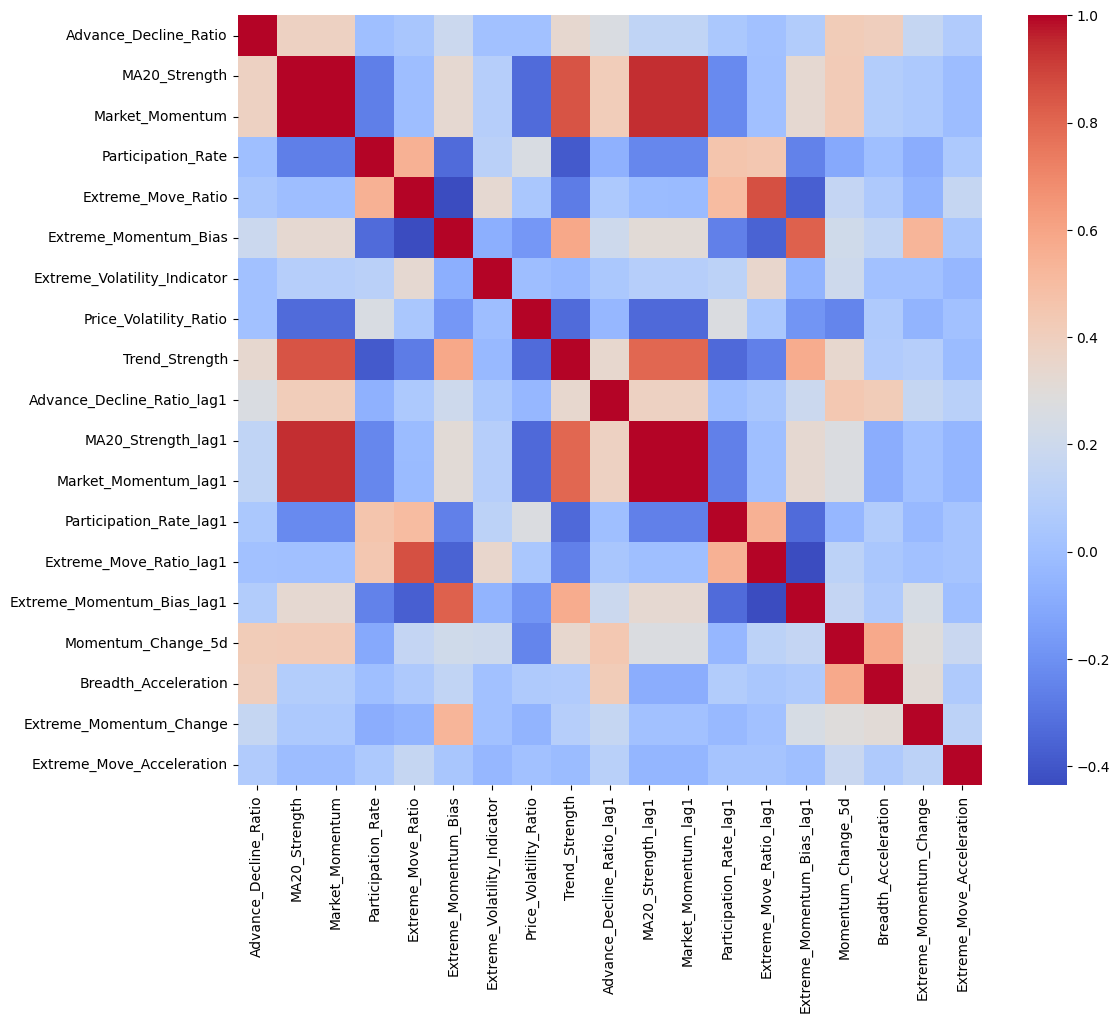

In [ ]:
# Feature correlation analysis
corr = features.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()

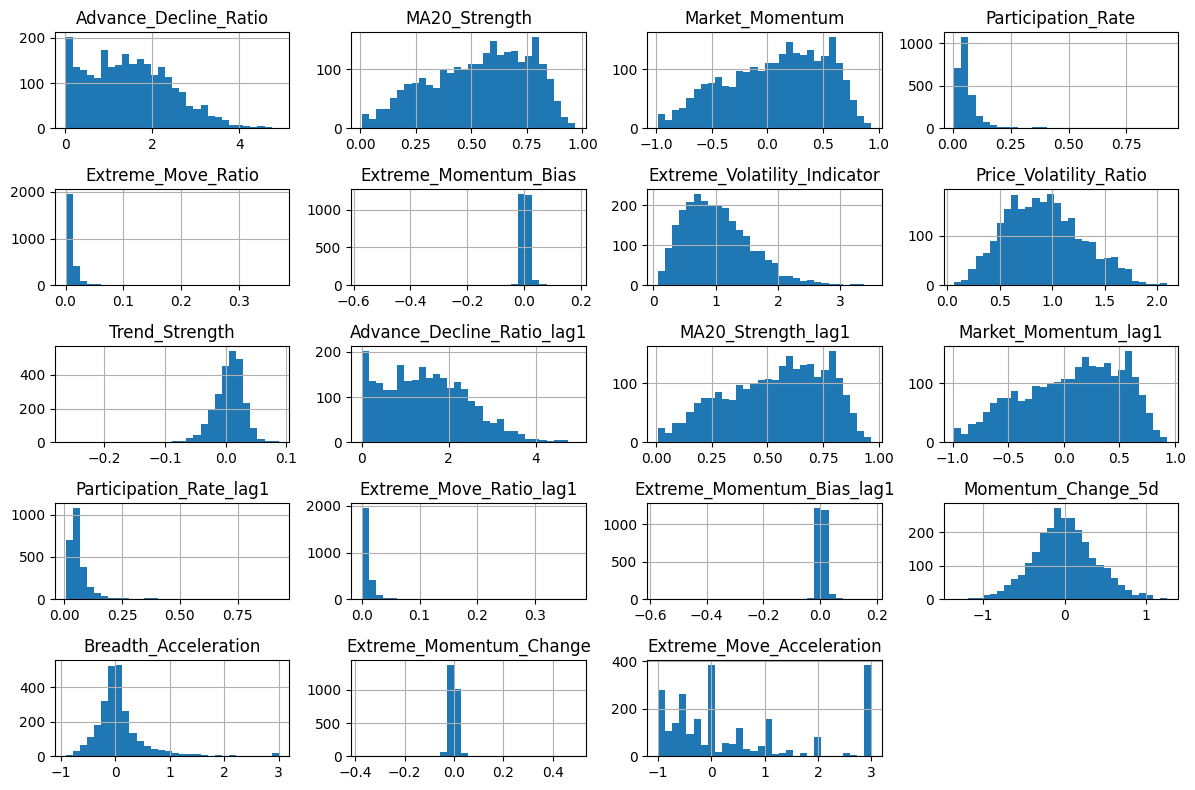

In [ ]:
# Feature distribution inspection for skewness and outliers
features.hist(figsize=(12,8), bins=30)
plt.tight_layout()
plt.show()

In [ ]:
changed_features = [
    col for col in features.columns
    if col in features_before.columns
    and not np.allclose(
        features_before[col].fillna(0),
        features[col].fillna(0)
    )
]

In [ ]:
def plot_feature_changes(before, after, cols, bins=50):
    for col in cols:
        plt.figure(figsize=(8, 4))
        plt.hist(before[col].dropna(), bins=bins, alpha=0.6, label='Before')
        plt.hist(after[col].dropna(), bins=bins, alpha=0.6, label='After')
        plt.title(f"{col}: Before vs After")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.show()

Changed features: ['Advance_Decline_Ratio', 'Extreme_Move_Ratio', 'Extreme_Momentum_Bias', 'Advance_Decline_Ratio_lag1', 'Extreme_Move_Ratio_lag1', 'Extreme_Momentum_Bias_lag1', 'Breadth_Acceleration', 'Extreme_Move_Acceleration']


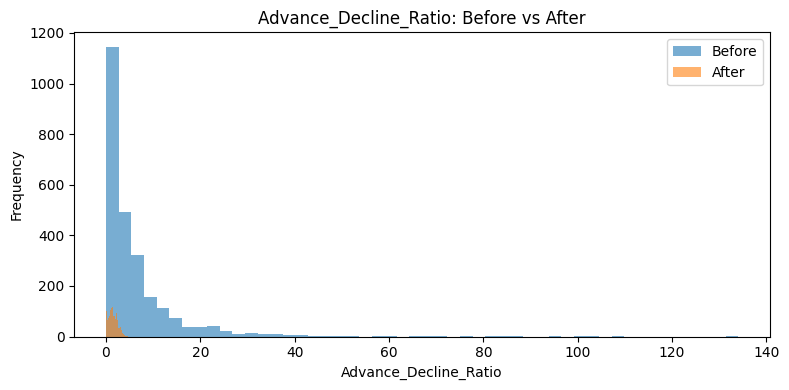

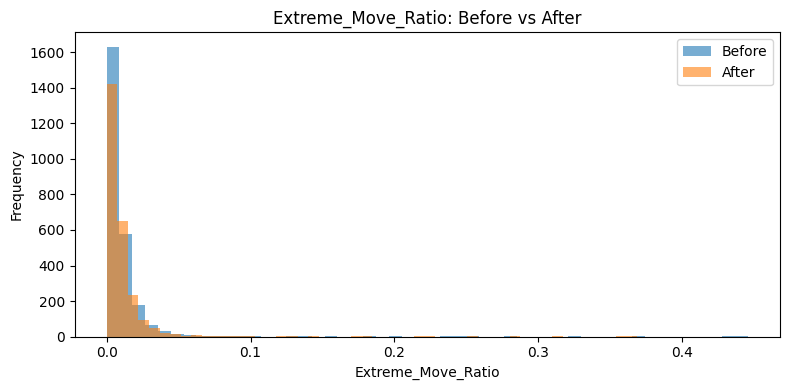

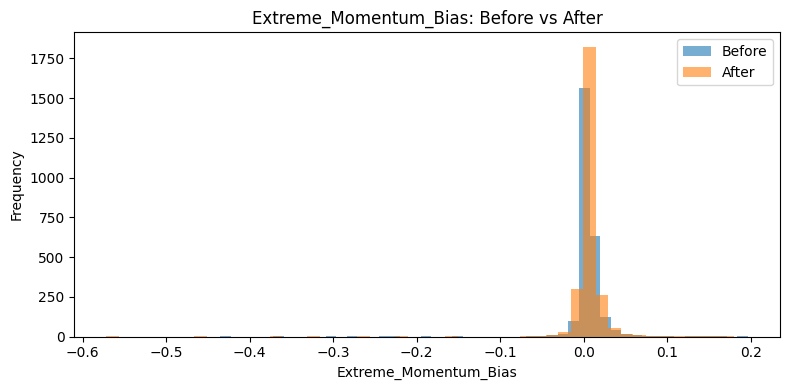

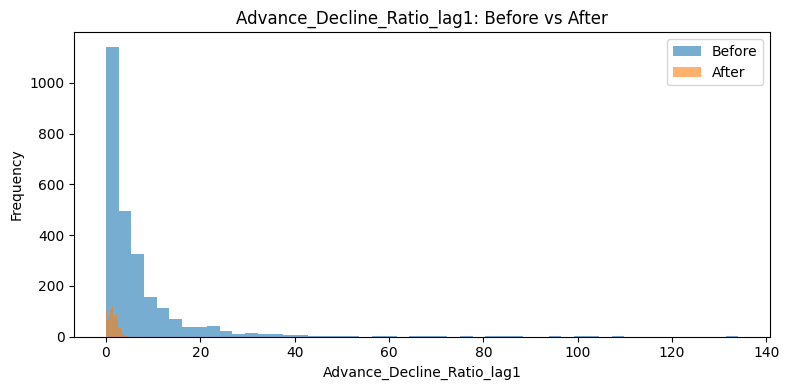

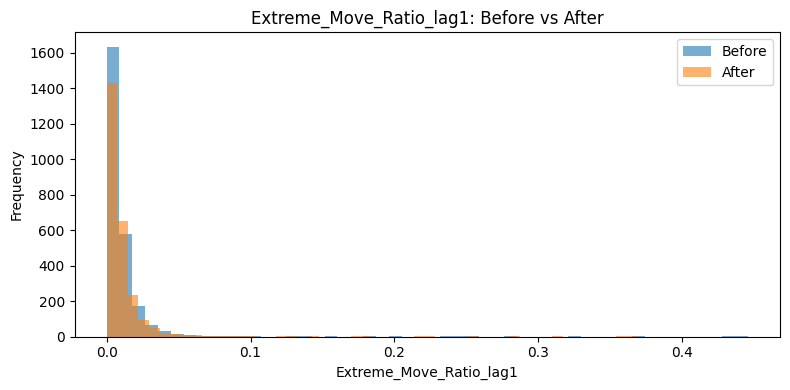

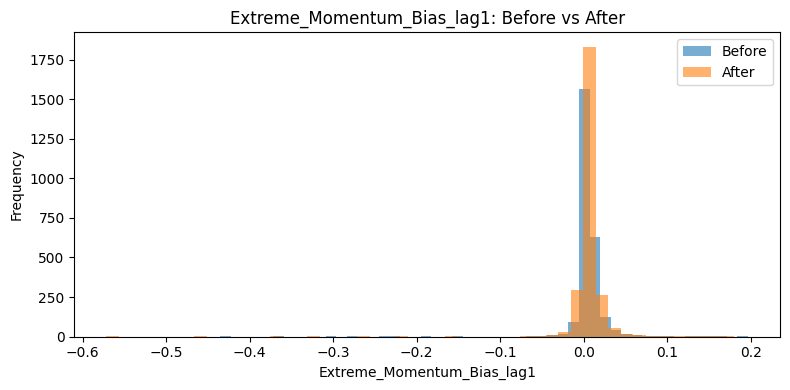

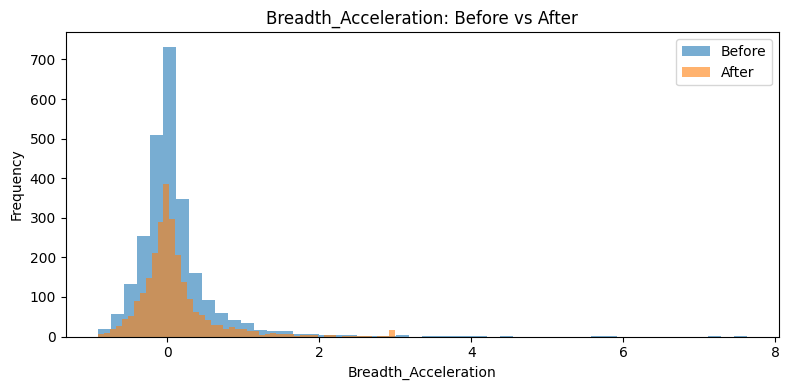

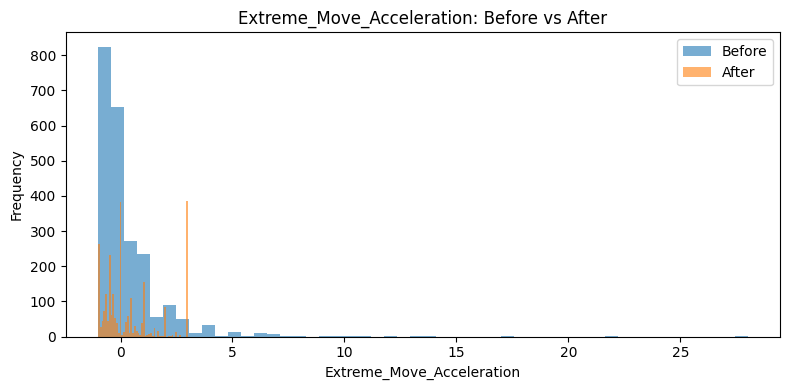

In [ ]:
def plot_feature_changes(before, after, cols, bins=50):
    for col in cols:
        plt.figure(figsize=(8, 4))
        # Filter out non-finite values (NaN and inf) from 'before' data
        data_before = before[col].dropna()
        data_before = data_before[np.isfinite(data_before)]

        # Filter out non-finite values (NaN and inf) from 'after' data
        data_after = after[col].dropna()
        data_after = data_after[np.isfinite(data_after)]

        # Check if there's data to plot after filtering
        if not data_before.empty:
            plt.hist(data_before, bins=bins, alpha=0.6, label='Before')
        else:
            print(f"Warning: No finite data to plot for 'Before' in column '{col}'.")

        if not data_after.empty:
            plt.hist(data_after, bins=bins, alpha=0.6, label='After')
        else:
            print(f"Warning: No finite data to plot for 'After' in column '{col}'.")

        plt.title(f"{col}: Before vs After")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.show()

print("Changed features:", changed_features)
plot_feature_changes(features_before, features, changed_features)

## Step 5: Train Time-Series ML Models for Regime Classification

In this step, we train machine learning models to **learn and predict market regimes** from engineered features.

We:
- Align feature data with regime labels by date and remove missing values.  
- Perform a time-aware train–test split to respect chronological order.  
- Use **Random Forest classifiers** with class balancing to handle regime imbalance.  
- Apply **walk-forward TimeSeries cross-validation** on the training set to assess stability across different market phases.  
- Train one **binary model per regime** (Bull, Bear, Low Vol, High Vol, etc.) instead of a single multi-class model.  
- Evaluate each model on a held-out test set using accuracy.  
- Save all trained models and diagnostics for later use.

This step converts engineered features into a set of predictive regime models, forming the bridge between **market data** and **regime-aware strategy construction** in the next stage.


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle

def fit_evaluate_timeseries_rf(X, y, train_frac=0.7, n_splits=3, rf_kwargs=None):
    """
    Fits and evaluates a Random Forest classifier on time-series data.
    """
    # Handle optional model hyperparameters
    rf_kwargs = rf_kwargs or {}

    # ---------------------------------------------------------
    # Train / test split (time-aware)
    # ---------------------------------------------------------
    # Use the first `train_frac` portion for training
    # Remaining data is held out as a final test set
    n = len(X)
    cut = int(n * train_frac)
    X_train, X_test = X.iloc[:cut], X.iloc[cut:]
    y_train, y_test = y.iloc[:cut], y.iloc[cut:]

    # ---------------------------------------------------------
    # TimeSeries cross-validation on training data
    # ---------------------------------------------------------
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_acc = []

    for tr_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        # Check if there are at least two unique classes in the training split
        if y_tr.nunique() < 2:
            print(f"Skipping CV fold due to insufficient data for training (only one class present).")
            continue

        # Train model on current fold
        m = RandomForestClassifier(random_state=42, n_jobs=-1, **rf_kwargs)
        m.fit(X_tr, y_tr)

        # Check if there are at least two unique classes in the validation split for evaluation
        if y_val.nunique() < 2:
             print(f"Skipping CV fold evaluation due to insufficient data for validation (only one class present).")
             continue

        cv_acc.append(accuracy_score(y_val, m.predict(X_val)))

    # Final fit on full train
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **rf_kwargs)
    model.fit(X_train, y_train)

    # Simple test eval
    test_acc = accuracy_score(y_test, model.predict(X_test))

    report = {
        "cv_fold_accuracy": cv_acc,
        "cv_mean_accuracy": float(np.mean(cv_acc)) if cv_acc else np.nan,
        "test_accuracy": float(test_acc),
        "train_size": int(len(X_train)),
        "test_size": int(len(X_test)),
    }
    return model, report

In [ ]:
def train_all_regime_models(features, regimes, output_path="regime_models.pkl"):
  # Stores trained models and their evaluation reports
    models = {}
    reports = {}

    # Align features & regimes labels by date
    common_index = features.index.intersection(regimes.index)
    X = features.loc[common_index]  # input features
    Y = regimes.loc[common_index]   # regime labels

    # ---------------------------------------------------------
    # Train one binary model per regime
    # ---------------------------------------------------------
    for regime in Y.columns:
        print(f"\n📈 Training model for regime: {regime}")
        y = Y[regime] # target for current regime (0/1)

        # Time-series RF with walk-forward CV and class balancing
        model, report = fit_evaluate_timeseries_rf(
            X=X,
            y=y,
            train_frac=0.7,
            n_splits=3,
            rf_kwargs={"n_estimators":100, "max_depth":10, "class_weight":"balanced"}
        )

        # Store model and diagnostics
        models[regime] = model
        reports[regime] = report
        print(report)

    # Save everything in one pickle file
    with open(output_path, "wb") as f:
        pickle.dump({"models": models, "reports": reports}, f)

    print(f"\nAll regime models saved to '{output_path}'")
    return models, reports


In [ ]:
# 1. Create regime target labels from price series
regimes = define_market_regimes(prices, lookback=20)

# Align features & regimes labeled by date
common_index = features.index.intersection(regimes.index)
X = features.loc[common_index]
y = regimes.loc[common_index]

# Drop any remaining NaNs after alignment to ensure clean data for training
# This is crucial because define_market_regimes's final shift(1) introduces NaNs.
combined_data = pd.concat([X, y], axis=1)
combined_data.dropna(inplace=True)
X = combined_data[X.columns]
y = combined_data[y.columns]

# Split data into training and test sets
train_frac = 0.7
cut = int(len(X) * train_frac)
X_train, X_test = X.iloc[:cut], X.iloc[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]
regimes_clean = y_test.copy() # Rename y_test to regimes_clean for clarity in evaluation function

# 2. Train and save all models
models, reports = train_all_regime_models(X_train, y_train, output_path="market_regime_models.pkl")

# 3. Evaluate models on test set
acc_table = pd.DataFrame(columns=['Regime', 'Accuracy'])
for regime in regimes_clean.columns:
    if regime in models:
        model = models[regime]
        # Check if there are at least two unique classes in the test split for evaluation
        if y_test[regime].nunique() < 2:
            print(f"Skipping test evaluation for regime '{regime}' due to insufficient data (only one class present).")
            continue
        test_acc = accuracy_score(regimes_clean[regime], model.predict(X_test))
        acc_table.loc[len(acc_table)] = [regime, test_acc]
    else:
        print(f"Model for regime '{regime}' not found.")

print("\n📊 Test Set Evaluation:")
print(acc_table)


📈 Training model for regime: High_Volatility
{'cv_fold_accuracy': [0.6741935483870968, 0.7129032258064516, 0.6709677419354839], 'cv_mean_accuracy': 0.6860215053763441, 'test_accuracy': 0.6597744360902256, 'train_size': 1240, 'test_size': 532}

📈 Training model for regime: Low_Volatility
{'cv_fold_accuracy': [0.6161290322580645, 0.6161290322580645, 0.6645161290322581], 'cv_mean_accuracy': 0.632258064516129, 'test_accuracy': 0.6823308270676691, 'train_size': 1240, 'test_size': 532}

📈 Training model for regime: Bull_Market
{'cv_fold_accuracy': [0.8548387096774194, 0.8193548387096774, 0.8129032258064516], 'cv_mean_accuracy': 0.8290322580645162, 'test_accuracy': 0.8345864661654135, 'train_size': 1240, 'test_size': 532}

📈 Training model for regime: Bear_Market
{'cv_fold_accuracy': [0.6451612903225806, 0.7032258064516129, 0.8387096774193549], 'cv_mean_accuracy': 0.7290322580645161, 'test_accuracy': 0.7857142857142857, 'train_size': 1240, 'test_size': 532}

📈 Training model for regime: Stab

In [ ]:
# ---------------------------------------------------------
# Align feature matrix with price data used for prediction
# ---------------------------------------------------------
# Ensure features and prices share the same timeline
common_index = features.index.intersection(prices.index)
X = features.loc[common_index]
close = prices.loc[common_index]

# ---------------------------------------------------------
# Initialize signal DataFrame
# ---------------------------------------------------------
# Stores regime predictions aligned with dates and prices
signals = pd.DataFrame(index=common_index)
signals["Close"] = close

# ---------------------------------------------------------
# Generate regime signals using trained models
# ---------------------------------------------------------
# Each model predicts whether its regime is active (0/1)
for regime_name, model in models.items():
    signals[regime_name] = model.predict(X)

In [ ]:
signals.tail()

Close  High_Volatility  Low_Volatility  Bull_Market  \
Date                                                                     
2025-11-18  23824.650391                0               0            0   
2025-11-19  23906.300781                0               1            0   
2025-11-21  23790.250000                0               1            0   
2025-11-24  23674.550781                0               1            0   
2025-11-26  23955.199219                0               1            0   

            Bear_Market  Stable_Bull  Stable_Bear  Stable_Low_Vol  
Date                                                               
2025-11-18            0            0            0               0  
2025-11-19            0            0            0               1  
2025-11-21            0            0            0               1  
2025-11-24            0            0            0               1  
2025-11-26            0            0            0               1

In [ ]:
signals.to_csv("market_regime_signals.csv")

## Step 6: Detailed Classification Metrics for Each Regime

In this step, we go beyond accuracy and evaluate each regime model using:

- **Precision** → how reliable positive regime predictions are  
- **Recall** → how well the model captures actual regime occurrences  
- **F1-score** → balance between precision and recall  

For each trained binary regime model, we generate a full classification report on the test set.

This helps us understand:
- Which regimes are easier or harder to detect,  
- Whether the model is biased toward false positives or false negatives, and  
- If regime predictions are robust enough to be used in downstream strategy logic.


In [ ]:
from sklearn.metrics import classification_report

print("\n" + "="*50)
print("PRECISION, RECALL, F1-SCORE FOR EACH REGIME")
print("="*50)

for regime_name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n📊 {regime_name}:")
    print(classification_report(y_test[regime_name], y_pred))


PRECISION, RECALL, F1-SCORE FOR EACH REGIME

📊 High_Volatility:
              precision    recall  f1-score   support

           0       0.73      0.93      0.82       538
           1       0.50      0.16      0.24       222

    accuracy                           0.71       760
   macro avg       0.61      0.55      0.53       760
weighted avg       0.66      0.71      0.65       760


📊 Low_Volatility:
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       460
           1       0.57      0.70      0.63       300

    accuracy                           0.68       760
   macro avg       0.67      0.68      0.67       760
weighted avg       0.69      0.68      0.68       760


📊 Bull_Market:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       520
           1       0.73      0.72      0.73       240

    accuracy                           0.83       760
   macro avg       0.80     

In [ ]:
def feature_importance_table(models, X_train, round_decimals=4):
    """
    Returns a sorted feature importance table:
    Rows   -> Features (sorted by mean importance)
    Columns-> Regimes
    Values -> Feature Importance
    """
#Code to print a table that shows tree-based feature importance extracted from separate
#Random Forest models trained for different market regimes.
#Higher values indicate that the model relied more heavily on that feature when making predictions.

    tables = []

    for regime, model in models.items():
        tables.append(
            pd.Series(
                model.feature_importances_,
                index=X_train.columns,
                name=regime
            )
        )

    importance_table = pd.concat(tables, axis=1)

    # ---- Sort by overall importance ----
    importance_table["Mean_Importance"] = importance_table.mean(axis=1)
    importance_table = importance_table.sort_values(
        by="Mean_Importance",
        ascending=False
    )

    return importance_table.round(round_decimals)

## Step 7: Feature Importance Analysis

In this step, we analyze feature importance from the trained Random Forest models to understand:

> **Which signals drive regime classification, and how their relevance changes across market environments.**

### Key Observations

**1️⃣ Universal Signals**  
Across all regimes, the most influential features are:
- **Trend_Strength** *(Index price relative to its 20-day MA)*  
- **Market_Momentum** *((Stocks above MA20 − Stocks below MA20) / Total stocks)*  
- **MA20 Strength** *(Stocks above MA20 / Total stocks)*  

These features consistently rank at the top because they capture **directional persistence and participation**, which remain important regardless of regime.

**2️⃣ Regime-Specific Signals**  
- **Extreme_Momentum_Change** and **Breadth_Acceleration** become more important during **high-volatility and transition regimes**, reflecting sudden shifts in market behavior.  
- **Participation-based features** dominate in **low-volatility and stable regimes**, where broad-based strength matters more than extremes.

### Interpretation

The results show that:
- Core trend and breadth signals explain market structure across all regimes.  
- Additional features gain importance depending on the market environment, indicating that **drivers of predictability are regime-dependent**.

This validates the motivation of the project:
> Different regimes are governed by different signals, and adaptive strategies should respect that.


In [ ]:
feature_importance = feature_importance_table(models=models,X_train=X_train)
feature_importance

High_Volatility  Low_Volatility  Bull_Market  \
Trend_Strength                         0.0895          0.1098       0.2391   
Market_Momentum_lag1                   0.0703          0.0776       0.1153   
Market_Momentum                        0.0510          0.0666       0.0893   
MA20_Strength_lag1                     0.0554          0.0587       0.0763   
MA20_Strength                          0.0513          0.0532       0.0771   
Momentum_Change_5d                     0.0725          0.0694       0.0462   
Breadth_Acceleration                   0.0646          0.0657       0.0354   
Price_Volatility_Ratio                 0.0420          0.0555       0.0411   
Participation_Rate                     0.0584          0.0695       0.0238   
Extreme_Volatility_Indicator           0.0480          0.0441       0.0397   
Participation_Rate_lag1                0.0502          0.0621       0.0259   
Extreme_Momentum_Change                0.0755          0.0454       0.0238   
Extreme_Momentum_Bias_lag1             0.0479          0.0287       0.0271   
Extreme_Move_Ratio                     0.0476          0.0308       0.0200   
Advance_Decline_Ratio_lag1             0.0315          0.0407       0.0324   
Advance_Decline_Ratio                  0.0349          0.0386       0.0282   
Extreme_Momentum_Bias                  0.0429          0.0299       0.0246   
Extreme_Move_Ratio_lag1                0.0442          0.0343       0.0212   
Extreme_Move_Acceleration              0.0224          0.0192       0.0135   

                              Bear_Market  Stable_Bull  Stable_Bear  \
Trend_Strength                     0.1975       0.2359       0.1801   
Market_Momentum_lag1               0.1008       0.1031       0.1277   
Market_Momentum                    0.1059       0.0781       0.0914   
MA20_Strength_lag1                 0.0789       0.0731       0.0895   
MA20_Strength                      0.0879       0.0706       0.0751   
Momentum_Change_5d                 0.0405       0.0727       0.0566   
Breadth_Acceleration               0.0335       0.0565       0.0472   
Price_Volatility_Ratio             0.0348       0.0404       0.0281   
Participation_Rate                 0.0310       0.0241       0.0273   
Extreme_Volatility_Indicator       0.0335       0.0477       0.0341   
Participation_Rate_lag1            0.0298       0.0246       0.0290   
Extreme_Momentum_Change            0.0257       0.0231       0.0219   
Extreme_Momentum_Bias_lag1         0.0375       0.0230       0.0358   
Extreme_Move_Ratio                 0.0350       0.0241       0.0324   
Advance_Decline_Ratio_lag1         0.0268       0.0227       0.0267   
Advance_Decline_Ratio              0.0228       0.0230       0.0218   
Extreme_Momentum_Bias              0.0282       0.0230       0.0306   
Extreme_Move_Ratio_lag1            0.0310       0.0205       0.0270   
Extreme_Move_Acceleration          0.0189       0.0138       0.0177   

                              Stable_Low_Vol  Mean_Importance  
Trend_Strength                        0.0924           0.1635  
Market_Momentum_lag1                  0.0738           0.0955  
Market_Momentum                       0.0568           0.0770  
MA20_Strength_lag1                    0.0536           0.0694  
MA20_Strength                         0.0541           0.0670  
Momentum_Change_5d                    0.0719           0.0614  
Breadth_Acceleration                  0.0623           0.0522  
Price_Volatility_Ratio                0.0617           0.0434  
Participation_Rate                    0.0678           0.0431  
Extreme_Volatility_Indicator          0.0440           0.0416  
Participation_Rate_lag1               0.0636           0.0407  
Extreme_Momentum_Change               0.0627           0.0397  
Extreme_Momentum_Bias_lag1            0.0301           0.0329  
Extreme_Move_Ratio                    0.0350           0.0321  
Advance_Decline_Ratio_lag1            0.0383           0.0313  
Advance_Decline_Ratio   

## Step 8: Backtesting & Evaluating the Regime-Based Strategies

In this step, we backtest the regime framework to assess whether adaptive positioning improves real trading performance.

We evaluate **two strategies**:
- **Four-Regime Adaptive Strategy** → continuously adjusts exposure across bull/bear and high/low volatility regimes.  
- **Crash Hedge Strategy** → stays invested in normal conditions and aggressively de-risks during persistent bear and crash-like environments.

### What We Analyze

- **Performance evaluation** including transaction costs to reflect realistic execution.  
- **Equity curve and drawdown comparison** against a Buy & Hold benchmark.  
- **Signal plots** over the full backtest period to visualize how regimes and positions evolve through time.  
- **Sanity checks** to verify that regime labels and positions behave logically across known market phases.  
- **Average position size by regime** to understand how much risk is typically taken in each environment.

### Objective

This step validates whether:
> **Regime-aware risk adaptation leads to better drawdown control and risk-adjusted returns than static Buy & Hold.**

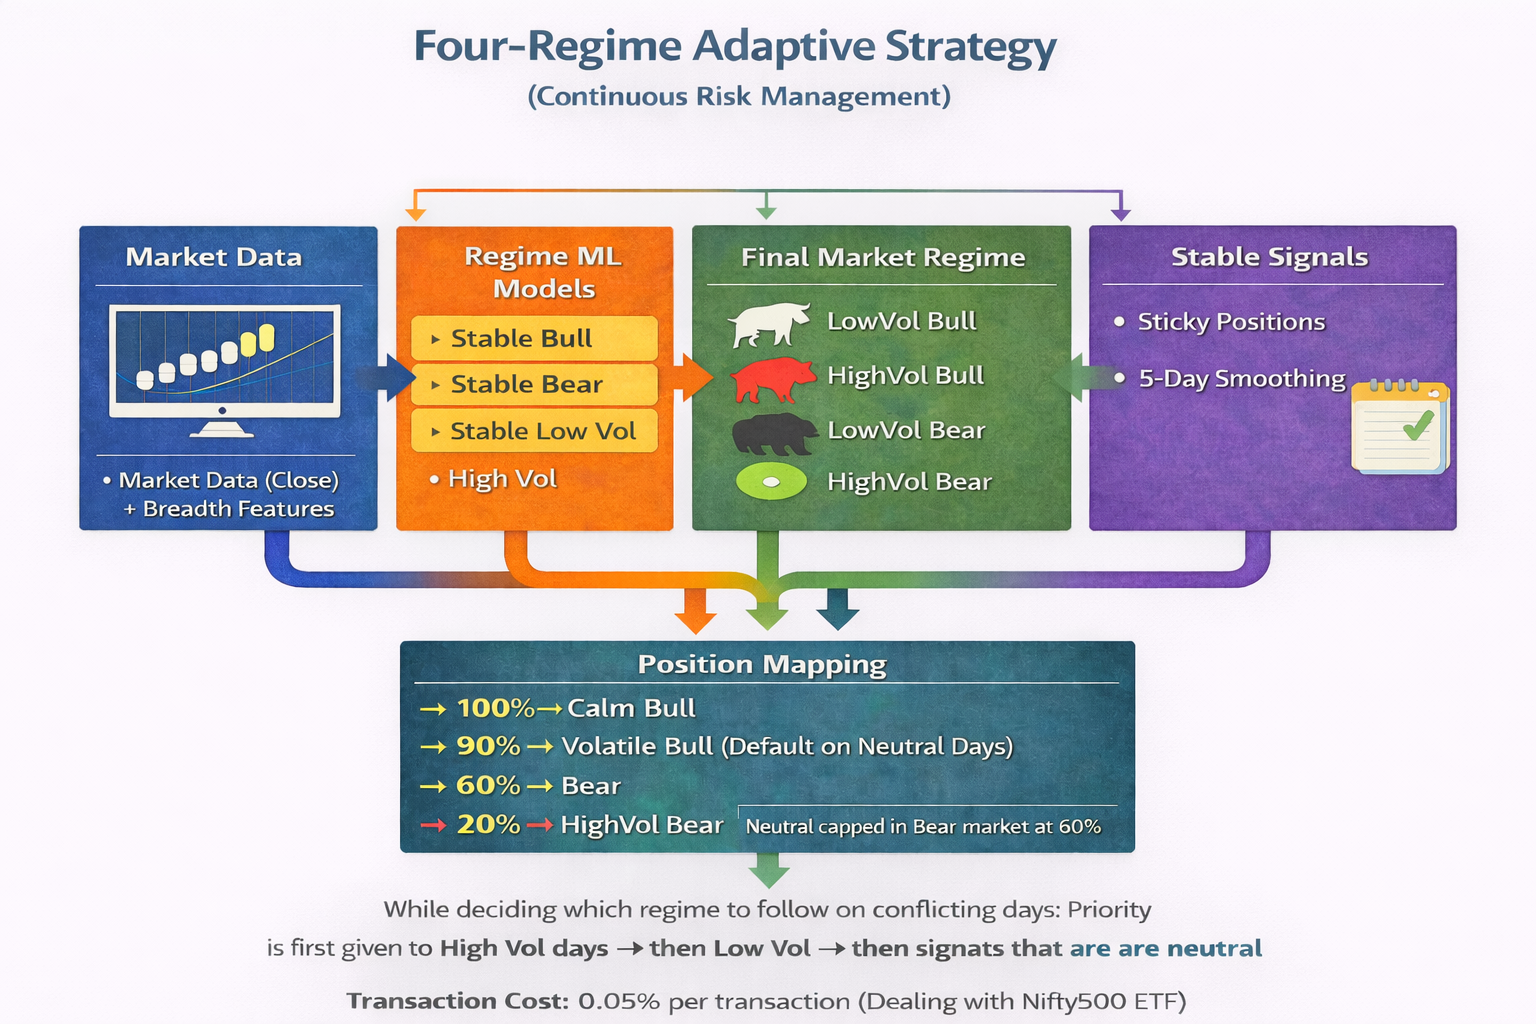

In [ ]:
def four_regime_strategy_clean(
    signals: pd.DataFrame,
    bull_calm: float = 1.0,
    bull_turb: float = 0.9,
    bear_calm: float = 0.6,
    bear_turb: float = 0.2
) -> pd.DataFrame:


    # Copy input signals to avoid side effects
    out = signals.copy()

    # ---------------------------------------------------------
    # 1. Extract regime signal flags
    # ---------------------------------------------------------
    bull     = out['Stable_Bull'] == 1
    bear     = out['Stable_Bear'] == 1
    low_vol  = out['Stable_Low_Vol'] == 1
    high_vol = out['High_Volatility'] == 1

    # ---------------------------------------------------------
    # 2. Assign a single exclusive regime per day
    # Priority: High Vol → Low Vol → Neutral
    # ---------------------------------------------------------
    out["Regime_Final"] = "Neutral"

    # High volatility regimes take precedence
    out.loc[high_vol & bear, "Regime_Final"] = "HighVol_Bear"
    out.loc[high_vol & bull, "Regime_Final"] = "HighVol_Bull"

    # Low volatility regimes only if still unassigned
    unassigned = out["Regime_Final"] == "Neutral"
    out.loc[unassigned & low_vol & bear, "Regime_Final"] = "LowVol_Bear"
    out.loc[unassigned & low_vol & bull, "Regime_Final"] = "LowVol_Bull"

    # ---------------------------------------------------------
    # 3. Map regimes to portfolio exposure
    # ---------------------------------------------------------
    out['Position'] = 0.9  # default Neutral position (non-bear)

    out.loc[out["Regime_Final"] == "LowVol_Bull",  'Position'] = bull_calm
    out.loc[out["Regime_Final"] == "HighVol_Bull", 'Position'] = bull_turb
    out.loc[out["Regime_Final"] == "LowVol_Bear",  'Position'] = bear_calm
    out.loc[out["Regime_Final"] == "HighVol_Bear", 'Position'] = bear_turb

    # Cap exposure during Neutral days inside a Bear market
    out.loc[
        (out["Regime_Final"] == "Neutral") & (bear),
        "Position"
    ] = bear_calm

    # ---------------------------------------------------------
    # 4. STICKY POSITION LOGIC
    # ---------------------------------------------------------
    # If regime does not change, keep previous position
    out['Position_Sticky'] = out['Position']

    for i in range(1, len(out)):
        if out['Regime_Final'].iloc[i] == out['Regime_Final'].iloc[i-1]:
            out.at[out.index[i], 'Position_Sticky'] = out['Position_Sticky'].iloc[i-1]

    # ---------------------------------------------------------
    # 5. Smooth exposure & apply Execution Lag
    # ---------------------------------------------------------
    # Rolling average smooths small regime flips
    out['Position_Smooth'] = out['Position_Sticky'].rolling(5, min_periods=1).mean()
    # Shift by one day to avoid look-ahead bias
    out['Position_Exec']   = out['Position_Smooth'].shift(1).fillna(0.5)

    return out

In [ ]:
def backtest_clean(df, price_col='Close', pos_col='Position_Exec',
                   capital=1_000_000, cost_rate=0.0005):

    # Work on a copy to avoid mutating input data
    out = df.copy()

    # Daily asset returns
    out['R'] = out[price_col].pct_change().fillna(0)

    # Position exposure(0 to 1 scale)
    out['Pos'] = out[pos_col].fillna(0)

    # Strategy P/L before costs
    out['Gross'] = out['Pos'] * out['R']

    # Transaction cost = position turnover * cost_rate
    turnover = out['Pos'].diff().abs().fillna(0)
    out['Cost'] = -turnover * cost_rate

    # Net strategy returns after costs
    out['Net'] = out['Gross'] + out['Cost']

    # Equity curves
    out['Equity'] = (1 + out['Net']).cumprod() * capital
    out['BH_Equity'] = (1 + out['R']).cumprod() * capital

    return out

In [ ]:
def evaluate_clean(returns_df):
    # Work on a copy to preserve original data
    r = returns_df.copy()

    # Extract strategy and benchmark series
    strat = r['Equity']      # strategy equity curve
    bh = r['BH_Equity']      # buy-and-hold equity curve
    net = r['Net']          # strategy daily returns
    ann_factor = np.sqrt(252)

    # Number of years in backtest
    n_days = len(r)
    years = n_days / 252

    # Peak-to-trough drawdowns
    strat_drawdown = strat / strat.cummax() - 1
    bh_drawdown = bh / bh.cummax() - 1

    # Buy-and-hold Sharpe
    bh_sharpe = r['R'].mean() / r['R'].std() * ann_factor if r['R'].std() != 0 else np.nan

    # CAGR calculations
    strat_cagr = (strat.iloc[-1] / strat.iloc[0])**(1 / years) - 1
    bh_cagr = (bh.iloc[-1] / bh.iloc[0])**(1 / years) - 1

    # ---------------------------------------------------------
    # Summary performance metrics
    # ---------------------------------------------------------
    result = {
        'Total Return %': (strat.iloc[-1] / strat.iloc[0] - 1) * 100,
        'CAGR % (Strategy)': strat_cagr * 100,
        'BH Return %': (bh.iloc[-1] / bh.iloc[0] - 1) * 100,
        'CAGR % (BH)': bh_cagr * 100,
        'Max Drawdown % (Strategy)': strat_drawdown.min() * 100,
        'BH Max Drawdown %': bh_drawdown.min() * 100,
        'Sharpe': net.mean() / net.std() * ann_factor if net.std() != 0 else np.nan,
        'BH Sharpe': bh_sharpe,
        'Win Rate %': (net > 0).mean() * 100,
        'Avg Position %': r['Pos'].mean() * 100,
        'Annual Vol %': net.std() * ann_factor * 100
    }

    # ---------------------------------------------------------
    # Formatted console output
    # ---------------------------------------------------------
    print("=======================================")
    print("📊 Strategy Evaluation Metrics")
    print("=======================================")
    for k, v in result.items():
        print(f"{k}: {v:.2f}")

    return pd.DataFrame(result, index=['Value']).round(3), strat_drawdown, bh_drawdown

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_strategy_results(returns_df, strat_drawdown, bh_drawdown):
    r = returns_df.copy()

    fig = make_subplots(
        rows=3, cols=1, shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=[
            "📈 Equity Curve: Strategy vs Buy & Hold",
            "📉 Drawdown Comparison",
            "🔍 Position / Exposure"
        ]
    )

    # Equity
    fig.add_trace(go.Scatter(
        x=r.index, y=r['Equity'],
        mode='lines', name='Strategy Equity'
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=r.index, y=r['BH_Equity'],
        mode='lines', name='Buy & Hold',
        line=dict(dash='dash')
    ), row=1, col=1)

    # Drawdown
    fig.add_trace(go.Scatter(
        x=strat_drawdown.index, y=strat_drawdown,
        mode='lines', name='Strategy DD'
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        x=bh_drawdown.index, y=bh_drawdown,
        mode='lines', name='BH DD',
        line=dict(dash='dash')
    ), row=2, col=1)

    # Position
    fig.add_trace(go.Scatter(
        x=r.index, y=r['Pos'],
        mode='lines', name='Position'
    ), row=3, col=1)

    fig.update_layout(
        height=900,
        title="📊 Strategy Tear Sheet (Interactive)",
        template="plotly_white",
        legend=dict(orientation="h", y=1.05)
    )

    fig.update_yaxes(range=[-0.05, 1.05], row=3, col=1)

    fig.show()

In [ ]:
print("TESTING ENHANCED FOUR REGIME STRATEGY...")
# ---------------------------------------------------------
# Run end-to-end test of the enhanced four-regime strategy
# ---------------------------------------------------------

# Convert regime signals into position sizing decisions
signals_regime_v2 = four_regime_strategy_clean(signals)

# Backtest strategy performance with transaction costs
results_regime_v2 = backtest_clean(signals_regime_v2)

# Compute performance and risk metrics
results, strat_dd, bh_dd = evaluate_clean(results_regime_v2)

# Visualize equity, drawdowns, and position behavior
plot_strategy_results(results_regime_v2, strat_dd, bh_dd)

TESTING ENHANCED FOUR REGIME STRATEGY...
📊 Strategy Evaluation Metrics
Total Return %: 255.65
CAGR % (Strategy): 13.46
BH Return %: 244.28
CAGR % (BH): 13.09
Max Drawdown % (Strategy): -18.81
BH Max Drawdown %: -38.30
Sharpe: 1.11
BH Sharpe: 0.83
Win Rate %: 56.08
Avg Position %: 80.73
Annual Vol %: 12.04


In [ ]:
# ---------------------------------------------------------
# Generate final regime classification
# ---------------------------------------------------------
# Apply regime-to-position logic and assign one regime per day
out = four_regime_strategy_clean(signals)

# ---------------------------------------------------------
# Inspect regime frequency distribution
# ---------------------------------------------------------
# Counts how often each final regime occurs
# Useful for sanity checks and exposure diagnostics
regime_counts = out["Regime_Final"].value_counts()
print(regime_counts)

Regime_Final
Neutral         1775
LowVol_Bull      384
HighVol_Bear     299
HighVol_Bull      44
LowVol_Bear       30
Name: count, dtype: int64


In [ ]:
# ---------------------------------------------------------
# Analyze signal vs neutral day distribution
# ---------------------------------------------------------
# Signal days = days with a clear, actionable regime
signal_days = (out["Regime_Final"] != "Neutral").sum()

# Neutral days = no strong or mixed regime signals
no_signal_days = (out["Regime_Final"] == "Neutral").sum()

total_days = len(out)

# ---------------------------------------------------------
# Print signal coverage statistics
# ---------------------------------------------------------
print(f"Total days: {total_days}")
print(f"Signal days: {signal_days} ({signal_days/total_days:.2%})")
print(f"No / Mixed signal days: {no_signal_days} ({no_signal_days/total_days:.2%})")

Total days: 2532
Signal days: 757 (29.90%)
No / Mixed signal days: 1775 (70.10%)


In [ ]:
# ---------------------------------------------------------
# Detect conflicting regime signals
# ---------------------------------------------------------

# Trend conflict: Bull and Bear signals active simultaneously
bull = out['Stable_Bull'] == 1
bear = out['Stable_Bear'] == 1
low_vol = out['Stable_Low_Vol'] == 1
high_vol = out['High_Volatility'] == 1

# Volatility conflict: Low and High volatility signals overlap
conflict_trend = bull & bear
conflict_vol   = low_vol & high_vol

# Store conflict flags for diagnostics and sanity checks
out["Trend_Conflict"] = conflict_trend
out["Vol_Conflict"]   = conflict_vol

# ---------------------------------------------------------
# Diagnose why days are classified as Neutral
# ---------------------------------------------------------
# Neutral days may arise from:
# - Conflicting trend signals
# - Conflicting volatility signals
# - No strong signals at all
neutral = out["Regime_Final"] == "Neutral"

# Breakdown of Neutral days by conflict type
neutral_breakdown = pd.Series({
    "Trend conflict only": (neutral & conflict_trend & ~conflict_vol).sum(),
    "Vol conflict only":   (neutral & conflict_vol & ~conflict_trend).sum(),
    "Both conflicts":     (neutral & conflict_trend & conflict_vol).sum(),
    "No signals at all":  (neutral & ~conflict_trend & ~conflict_vol).sum()
})

print(neutral_breakdown)

Trend conflict only       0
Vol conflict only         4
Both conflicts            0
No signals at all      1771
dtype: int64


In [ ]:
# ---------------------------------------------------------
# Regime-wise exposure diagnostics
# ---------------------------------------------------------
# Compute average position levels for each final regime
# Helps verify that exposure mapping behaves as intended
out.groupby("Regime_Final")[[
    "Position",        # raw regime-based exposure
    "Position_Sticky", # exposure after whipsaw control
    "Position_Exec"    # final, lagged executable exposure
]].mean()

Position  Position_Sticky  Position_Exec
Regime_Final                                          
HighVol_Bear  0.200000         0.200000       0.399532
HighVol_Bull  0.900000         0.900000       0.903182
LowVol_Bear   0.600000         0.600000       0.716000
LowVol_Bull   1.000000         1.000000       0.953073
Neutral       0.873127         0.869408       0.843685

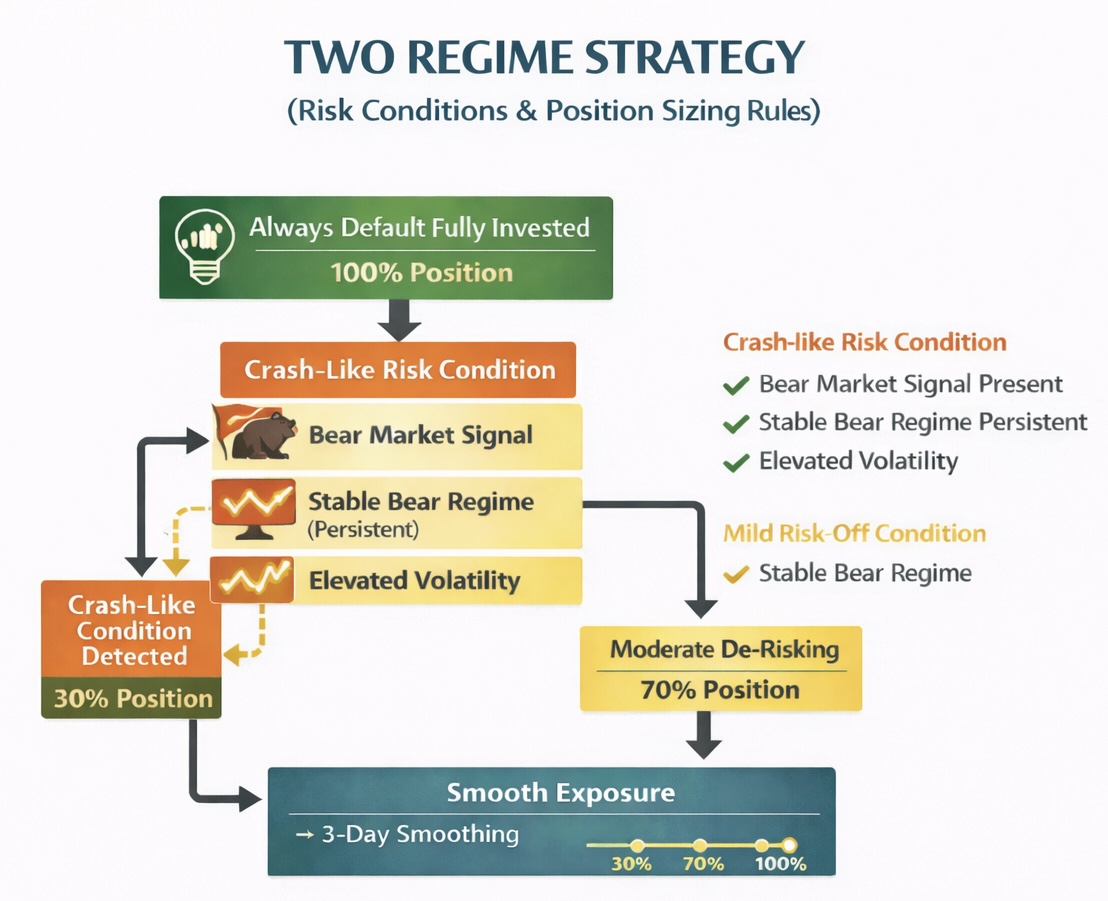

In [ ]:
def two_regime_strategy(signals: pd.DataFrame) -> pd.DataFrame:
    # Work on a copy to avoid mutating original signals
    out = signals.copy()

    # Default position
    # Fully invested unless risk conditions are triggered
    out['Position'] = 1.0

    # ---------------------------------------------------------
    # Crash-like risk condition
    # ---------------------------------------------------------
    # Severe risk-off when:
    # - Bear market signal is present
    # - Bear regime is stable (persistent)
    # - Volatility is elevated
    crash_like = (
        (out['Bear_Market'] == 1) &
        (out['Stable_Bear'] == 1) &
        (out['High_Volatility'] == 1)
    )

    # ---------------------------------------------------------
    # Mild risk-off condition
    # ---------------------------------------------------------
    # Reduce exposure during stable bear regimes
    mild_risk_off = (
        (out['Stable_Bear'] == 1)
    )

    # ---------------------------------------------------------
    # Position sizing rules
    # ---------------------------------------------------------
    # Moderate de-risking in bear markets
    out.loc[mild_risk_off, 'Position'] = 0.7
    # Aggressive de-risking during crash-like conditions
    out.loc[crash_like, 'Position']    = 0.3

    # ---------------------------------------------------------
    # Smooth exposure and apply execution lag
    # ---------------------------------------------------------
    # Short smoothing window to avoid abrupt position changes
    out['Position_Smooth'] = out['Position'].rolling(3, min_periods=1).mean()
    # Lag positions by one day to avoid look-ahead bias
    out['Position_Exec']   = out['Position_Smooth'].shift(1).fillna(1.0)

    return out

In [ ]:
# ---------------------------------------------------------
# Run tail-hedge (crash protection) strategy
# ---------------------------------------------------------
# Convert regime signals into defensive position sizing
signal_r = two_regime_strategy(signals)

# Backtest tail-hedge strategy with transaction costs
results_tail_hedge = backtest_clean(signal_r)

# Evaluate performance and risk metrics
results1, strat_dd1, bh_dd1 = evaluate_clean(results_tail_hedge)

# Visualize equity curve, drawdowns, and exposure behavior
plot_strategy_results(results_tail_hedge, strat_dd1, bh_dd1)

📊 Strategy Evaluation Metrics
Total Return %: 283.95
CAGR % (Strategy): 14.33
BH Return %: 244.28
CAGR % (BH): 13.09
Max Drawdown % (Strategy): -17.88
BH Max Drawdown %: -38.30
Sharpe: 1.07
BH Sharpe: 0.83
Win Rate %: 56.20
Avg Position %: 89.51
Annual Vol %: 13.38


In [ ]:
# ---------------------------------------------------------
# Analyze exposure by bear-regime state
# ---------------------------------------------------------
# Group by raw Bear_Market and Stable_Bear signals
# to understand how position sizing behaves across:
# - Early / unstable bear phases
# - Confirmed (stable) bear regimes
out.groupby(
    ['Bear_Market', 'Stable_Bear']
)['Position_Exec'].mean()

Bear_Market  Stable_Bear
0            0              0.883745
             1              0.760000
1            0              0.833430
             1              0.505560
Name: Position_Exec, dtype: float64

In [ ]:
# ---------------------------------------------------------
# Identify crash-like regime conditions
# ---------------------------------------------------------
# Crash-like = confirmed bear + high volatility + price below long-term trend
crash_like = (
    (out['Bear_Market'] == 1) &
    (out['Stable_Bear'] == 1) &
    (out['High_Volatility'] == 1)
)

# ---------------------------------------------------------
# Inspect position behavior immediately after crash ends
# ---------------------------------------------------------
# Select days where:
# - Yesterday was crash-like
# - Today is no longer crash-like
# Used to verify how quickly exposure recovers post-crash
out[['Position_Exec']].loc[
    (crash_like.shift(1) == 1) & (crash_like == 0)
].head(10)

Position_Exec
Date                     
2015-09-22           0.20
2016-02-05           0.20
2016-02-18           0.20
2016-03-01           0.62
2016-09-22           0.76
2016-10-20           0.20
2016-11-01           0.20
2016-11-03           0.34
2016-12-08           0.20
2016-12-12           0.34

## Summary & Key Takeaways

This project demonstrates that:

- Market regimes can be systematically identified using trend, volatility, and breadth.
- Persistence filters stabilize noisy trend signals.
- Immediate volatility signals improve risk control.
- Regime-based exposure leads to smoother equity curves and better drawdown management.

Rather than predicting prices, the framework focuses on:

> **Adapting intelligently to the market environment.**